In [108]:
!pip install pandas matplotlib seaborn sklearn tensorflow
!pip install "numpy<2"


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [110]:
# Load the dataset
file_path = "./proccessedBookings.csv"
df = pd.read_csv(file_path)

# Display basic info
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29990 entries, 0 to 29989
Data columns (total 47 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Unnamed: 0.1                               29990 non-null  int64  
 1   Unnamed: 0                                 29509 non-null  float64
 2   name                                       29509 non-null  object 
 3   original_price                             29509 non-null  float64
 4   discounted_price                           29509 non-null  float64
 5   discount                                   29509 non-null  object 
 6   review_score                               29505 non-null  float64
 7   review_title                               28271 non-null  float64
 8   number_of_reviews                          29505 non-null  float64
 9   star_rating                                29202 non-null  float64
 10  is_apartment          

None

,Unnamed: 0.1,Unnamed: 0,name,original_price,discounted_price,discount,review_score,review_title,number_of_reviews,star_rating,...,"neighborhood_Midtown East, New York","neighborhood_Murray Hill, New York",neighborhood_New York,"neighborhood_NoMad, New York","neighborhood_SoHo, New York","neighborhood_Tribeca, New York","neighborhood_Union Square, New York","neighborhood_Upper East Side, New York","neighborhood_Upper West Side, New York","neighborhood_Washington Heights, New York"
0,0,0.0,Iroquois New York Times Square,292.0,218.0,True,8.5,4.0,2625.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,Four Points by Sheraton New York Downtown,130.0,111.0,True,7.8,3.0,1987.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2.0,"The Mayfair Hotel Times Square, Ascend Hotel C...",141.0,141.0,False,8.6,5.0,1895.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3.0,The Washington by LuxUrban,160.0,160.0,False,7.7,3.0,9442.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4.0,Hampton Inn by Hilton New York Times Square,152.0,152.0,False,7.8,3.0,2432.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
# Feature Engineering
df['log_time_to_travel'] = np.log1p(df['time_to_travel'])  # Log transformation
df['long_stay'] = (df['length_of_stay'] > 3).astype(int)  # 1 if stay > 3 nights, else 0

In [112]:
print(df['discounted_price_per_night'].dtype)
print(df['discounted_price_per_night'])

float64
0        218.0
1        111.0
2        141.0
3        160.0
4        152.0
         ...  
29985    285.8
29986    244.4
29987    338.6
29988    317.4
29989    350.0
Name: discounted_price_per_night, Length: 29990, dtype: float64


In [113]:
# Define Features and Target
df_cleaned = df.dropna(subset=['log_time_to_travel', 'length_of_stay', 'long_stay', 'discounted_price_per_night'])
X = df_cleaned[['log_time_to_travel', 'length_of_stay', 'long_stay']]  # Features
y = df_cleaned['discounted_price_per_night']  # Target Variable

In [114]:
print(X.shape)
print(y.shape)
print(X.head())  # Check if X contains valid data
print(y.head())  # Check if y contains valid target values

(29509, 3)
(29509,)
   log_time_to_travel  length_of_stay  long_stay
0            0.693147             1.0          0
1            0.693147             1.0          0
2            0.693147             1.0          0
3            0.693147             1.0          0
4            0.693147             1.0          0
0    218.0
1    111.0
2    141.0
3    160.0
4    152.0
Name: discounted_price_per_night, dtype: float64


In [115]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [116]:
# Normalize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [117]:
# Train Multiple Regression Models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'Gaussian Process': GaussianProcessRegressor(kernel=C(1.0) * RBF(1.0)),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
    'SVR': SVR(kernel='rbf')
}

In [ ]:
X_train_scaled_clean = X_train_scaled[~np.isnan(X_train_scaled).any(axis=1)]
y_train_clean = y_train[~np.isnan(X_train_scaled).any(axis=1)]

In [119]:
nan_vals = np.isnan(y_train).sum()
print(f"Number of NaN values in X_train_scaled: {nan_vals}")

Number of NaN values in X_train_scaled: 0


In [ ]:
# Train and Evaluate Models
results = {}
for name, model in models.items():
     model.fit(X_train_scaled_clean, y_train)
     y_pred = model.predict(X_test_scaled)
     results[name] = {
          'R2': r2_score(y_test, y_pred),
          
          'MAE': mean_absolute_error(y_test, y_pred),
          'MSE': mean_squared_error(y_test, y_pred),
          'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
     }

c:\Users\Ilai\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\Ilai\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [121]:
# Convert Results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)


                         R2        MAE           MSE        RMSE
Linear Regression  0.013849  62.064278   6491.743127   80.571354
Decision Tree      0.237680  53.018825   5018.279756   70.839818
Gaussian Process  -0.746472  82.215133  11496.863253  107.223427
Random Forest      0.242053  52.844898   4989.496987   70.636372
Gradient Boosting  0.256876  52.196487   4891.914537   69.942223
SVR               -0.001829  59.555006   6594.951546   81.209307


In [ ]:
# Plot Residuals for Best Model (Based on R² Score)
best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

In [147]:
!pip install --upgrade seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl (7.8 MB)

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Ilai\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
Consider using the `--user` option or check the permissions.


c:\Users\Ilai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

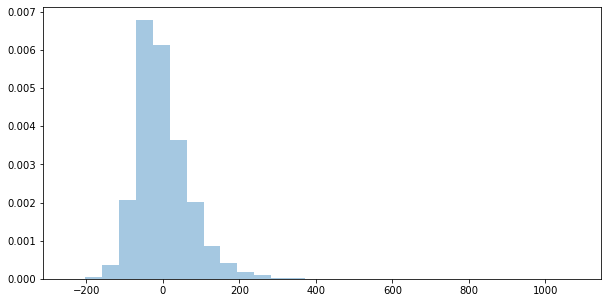

In [153]:
plt.figure(figsize=(10, 5))
sns.distplot(residuals, bins=30, kde=True)
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



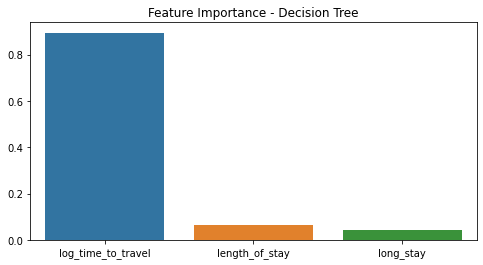

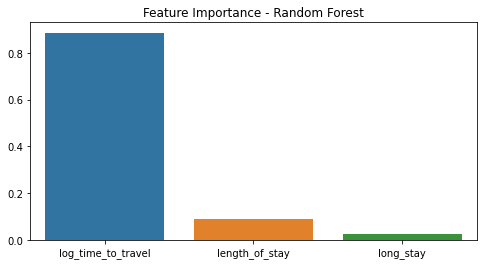

In [149]:
# Feature Importance for Decision Tree and Random Forest
for model_name in ['Decision Tree', 'Random Forest']:
    model = models[model_name]
    feature_importance = model.feature_importances_
    plt.figure(figsize=(8, 4))
    sns.barplot(x=X.columns, y=feature_importance)
    plt.title(f'Feature Importance - {model_name}')
    plt.show()

In [150]:
# Neural Network Model 1
nn_model_1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
nn_model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])
nn_model_1.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_data=(X_test_scaled, y_test), verbose=0)

c:\Users\Ilai\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [151]:
# Neural Network Model 2 with Embedding
embedding_dim = 5
input_layer = layers.Input(shape=(X_train_scaled.shape[1],))
embedding_layer = layers.Dense(embedding_dim, activation='relu')(input_layer)
hidden_layer = layers.Dense(32, activation='relu')(embedding_layer)
output_layer = layers.Dense(1)(hidden_layer)
nn_model_2 = keras.Model(inputs=input_layer, outputs=output_layer)
nn_model_2.compile(optimizer='adam', loss='mse', metrics=['mae'])
nn_model_2.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_data=(X_test_scaled, y_test), verbose=0)